<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/4.System-analysis/CSTR_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -qq control

In [2]:
import numpy as  np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import control as ct
from control.iosys import linearize, find_eqpt
import control.matlab as cm
from control.pzmap import pzmap
from scipy import linalg

In [3]:
# Ajustando o tamanho da fonte e espaçamento de linha de saída das células: OPCIONAL
from IPython.display import HTML
shell = get_ipython()

def adjust_font_and_line_spacing():
    display(HTML('''
    <style>
        body {
            font-size: 25px;
        }
    </style>
    '''))

if adjust_font_and_line_spacing not in shell.events.callbacks['pre_execute']:
    shell.events.register('pre_execute', adjust_font_and_line_spacing)


In [4]:
# importar modelo do processo
!git clone https://github.com/juliosdutra/Controle_de_Processos_UFES.git

fatal: destination path 'Controle_de_Processos_UFES' already exists and is not an empty directory.


In [5]:
%cd Controle_de_Processos_UFES/Miscellaneous
%run CSTR_model.ipynb

/content/Controle_de_Processos_UFES/Miscellaneous


In [6]:
if callable(CSTR_modificado) and callable(medida):
    print("As funções necessárias estão definidas e podem ser executadas.")
else:
    print("As funções não foram definidas")

As funções necessárias estão definidas e podem ser executadas.


In [7]:
# Determinar o modelo linearizado do processo relacionando as mudanças nas
# variáveis de estado (c_A, T e T_C), com as
# variáveis de entrada (q, q_C, T_Ci e c_Ai).

#  Instanciar o sistema I/O para o tanque
reator = ct.NonlinearIOSystem(
            CSTR_modificado,
            outfcn = medida,
            states = ('cA','T', 'Tc'),
            inputs = ('q','qc','Tci','cAi'),
            outputs =('cA','T', 'Tc'))

In [8]:
# ponto de linearização
# xs = [0.5, 350.0, 300.0]
# us = [100.0, 125.0, 288.0, 1.0]
xs=  [0.11538, 383.38181, 300.0]
us=  [115, 125.0, 300, 1.0]

xeq, ueq, result = find_eqpt(reator, x0=xs, u0=us,
                             y0=None, return_result=True)

reator_linear = linearize(reator, xeq=xeq, ueq=ueq)

In [9]:
# modelo linear
A = reator_linear.A
B = reator_linear.B
C = reator_linear.C
D = reator_linear.D

# conversão
sys = ct.ss(A,B,C,D)
sys

<LinearIOSystem:sys[4]:['u[0]', 'u[1]', 'u[2]', 'u[3]']->['y[0]', 'y[1]', 'y[2]']>

# Convertendo um espaço de estados em uma função de transferência

In [10]:
from sympy import symbols, Poly, eye

def ABCD_to_tf(A,B,C,D):
    '''  É utilizada para manipulação simbólica e algébrica para converter um espaço
    de estados dado por (A, B, C, D) para uma matriz de funções de  transferência
    no domínio de Laplace.'''
    s = symbols('s')
    n = A.shape[0]
    G = C*(s*eye(n) - A).inv()*B + D
    return G.as_immutable()

def get_tf(g_exp):
    '''Extrai os coeficiente do numerador e do denominador de uma função de transferência
    simbólica e converte para um função de transferências numérica, a qual pode ser usada
    para extrair propriedades dos sistema.'''
    s = symbols('s')
    num, den = g_exp.as_numer_denom()
    num_float = [float(i) if abs(float(i)) > 1e-5 else 0.0 for i in Poly(num, s).all_coeffs()]
    den_float = [float(i) if abs(float(i)) > 1e-5 else 0.0 for i in Poly(den, s).all_coeffs()]
    den_ = den_float[-1]
    return ct.tf(np.array(num_float)/den_,
                 np.array(den_float)/den_)


G = ABCD_to_tf(A,B,C,D) # fornece a matriz de funções de transferência
G.simplify()

Matrix([
[(72.9840318873426*s**2 + 124.720667562394*s - 3646.18153769544)/(7643.03585575267*s**3 + 183509.624261282*s**2 + 1461379.56503487*s + 3435510.09547234), (-1.74052947593184e-15*s**3 - 2.22787772919275e-13*s + 935.066013422273)/(7643.03585575267*s**3 + 183509.624261282*s**2 + 1461379.56503487*s + 3435510.09547234), (1.11022302089879e-14*s**3 + 1.42108546675045e-12*s - 5964.45982970599)/(7643.03585575267*s**3 + 183509.624261282*s**2 + 1461379.56503487*s + 3435510.09547234), (8789.49123331642*s**2 - 13130.5170899866*s - 657281.788358878)/(7643.03585575267*s**3 + 183509.624261282*s**2 + 1461379.56503487*s + 3435510.09547234)],
[(-0.768702926654927*s**2 + 47.4215482108894*s + 413.694072267511)/(1.50011553331044*s**3 + 36.017839385002*s**2 + 286.82819588256*s + 674.295156574975),                                   (-3.07502024066077*s - 78.4251065014578)/(1.50011553331044*s**3 + 36.017839385002*s**2 + 286.82819588256*s + 674.295156574975),                                   (19.614481

In [11]:
# Algumas funções de transferência

# saídas =  cA, T, Tc (ny = 3)
# entradas = q, qc, Tc_i, cA_i (nu = 4)

get_tf(G[0,0]) # cA(s)/q(s)

TransferFunction(array([ 2.12440161e-05,  3.63033914e-05, -1.06132174e-03]), array([0.00222472, 0.05341554, 0.42537484, 1.        ]))

In [12]:
get_tf(G[0,3]) # cA(s)/c_Ai

TransferFunction(array([ 0.00255842, -0.003822  , -0.19132   ]), array([0.00222472, 0.05341554, 0.42537484, 1.        ]))

In [13]:
get_tf(G[1,1]) # T(s)/qc(s)

TransferFunction(array([-0.00456035, -0.11630679]), array([0.00222472, 0.05341554, 0.42537484, 1.        ]))

In [14]:
get_tf(G[1,3]) # T(s)/cA_i(s)

TransferFunction(array([ 13.03507985, 101.02337458]), array([0.00222472, 0.05341554, 0.42537484, 1.        ]))

# Calcular polos, zeros e ganhos e verificar a estabilidade.

In [15]:
# Ganhos
K = sys.dcgain()
K

array([[-1.06132174e-03,  2.72176762e-04, -1.73612059e-03,
        -1.91319999e-01],
       [ 6.13520753e-01, -1.16306792e-01,  7.41880443e-01,
         1.01023375e+02],
       [ 1.18753328e-01, -1.48940310e-01,  9.50038271e-01,
         1.95541258e+01]])

In [16]:
# Polos
sys.pole()

array([-9.95226231+3.23081123j, -9.95226231-3.23081123j,
       -4.105519  +0.j        ])

In [17]:
# Zeros
ny = 3
nu = 4
nx = sys.nstates

z = []
for i in range(ny):
    for j in range(nu):
      g = get_tf(G[i,j])
      z.append(g.zero())
z

[array([-7.97403668+0.j,  6.26516058+0.j]),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([ 9.42671016+0.j, -7.93282197+0.j]),
 array([69.44045981+0.j, -7.75011551+0.j]),
 array([-25.5039318+0.j]),
 array([-25.5039318+0.j]),
 array([-7.75011551+0.j]),
 array([69.44045981+0.j]),
 array([-8.12996405+1.493235j, -8.12996405-1.493235j]),
 array([-8.12996405+1.493235j, -8.12996405-1.493235j]),
 array([], dtype=complex128)]

In [18]:
# checar a estabilidade
p, V = linalg.eig(A)

print('\n autovalores = \n', p)
print('\n autovetores = \n', V)

if any(np.real(p)>0):
    print('\n O sistema é INSTÁVEL.')
else:
    print('\n O sistema é ESTÁVEL.')


 autovalores = 
 [-9.95226231+3.23081123j -9.95226231-3.23081123j -4.105519  +0.j        ]

 autovetores = 
 [[ 0.00343481-0.00071357j  0.00343481+0.00071357j -0.00257921+0.j        ]
 [-0.93363601+0.j         -0.93363601-0.j          0.92472867+0.j        ]
 [ 0.20174812+0.29598848j  0.20174812-0.29598848j  0.38061822+0.j        ]]

 O sistema é ESTÁVEL.


In [19]:
# checar controlabilidade e observabilidade do processo.
OB = ct.obsv(A,C)
CO = ct.ctrb(A,B)
if np.linalg.matrix_rank(OB) == sys.nstates:
    print('\n O sistema é observável.')

if np.linalg.matrix_rank(CO) == sys.nstates:
    print('\n O sistema é controlável.')


 O sistema é observável.

 O sistema é controlável.


# Comparar os modelos via simulação

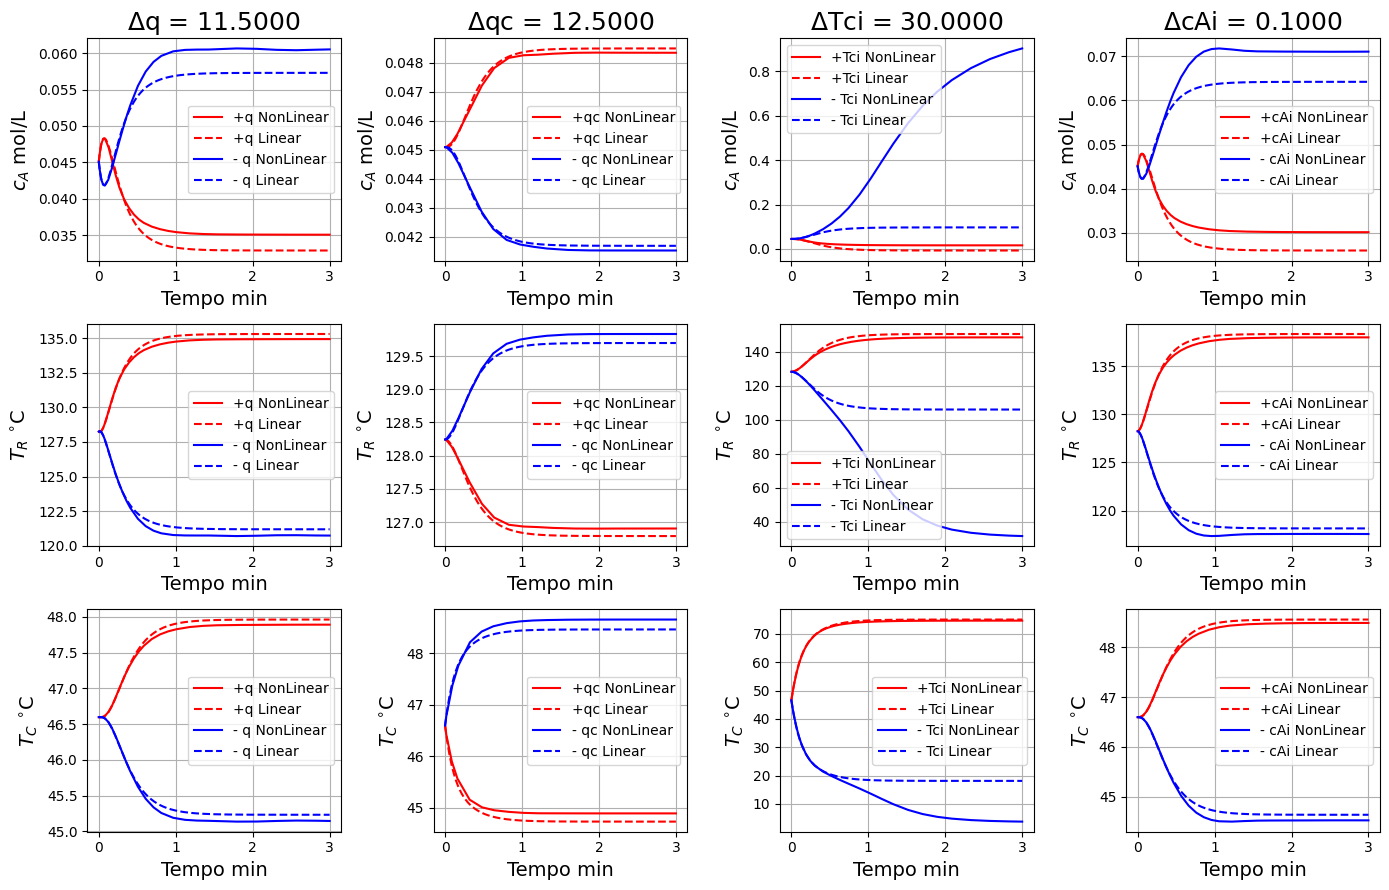

In [20]:
x0 = xeq
u0 = ueq
u_lim = np.zeros(4)
tspan = [0,3]
t = np.arange(tspan[0],tspan[-1]+0.1,0.1)

n_testes = 4
delta = 0.10 # 10% de variação em algum u0 indicado em pos
pos = [0,1,2,3] # (q, q_C, T_Ci e c_Ai).
var = ['q','qc','Tci','cAi']

tipo = ['+','- ']
cor = ['r','b']

f, ax = plt.subplots(nrows=3, ncols=n_testes,figsize=(14,9))

for i in range(n_testes):

    # começar com variação positiva
    sinal = +1
    du = np.zeros(4)
    du[pos[i]] = delta*u0[pos[i]]

    modelo_nlinear = lambda t,x: CSTR_modificado(t, x, u0)

    ax1 = ax[0][i]  # 1a linha: cA
    ax2 = ax[1][i]  # 2a linha: Tr
    ax3 = ax[2][i]  # 3a linha: Tc


    for j in range(2):

        u0 = u0 + sinal*du
        modelo_nlinear = lambda t,x: CSTR_modificado(t, x, u0)

        sol = solve_ivp(modelo_nlinear, tspan, x0, method='BDF')
        t = sol.t
        x = sol.y.T

        ax1.plot(t,x[:,0], '-', color=cor[j], label=str(tipo[j])+var[i]+' NonLinear')
        ax2.plot(t,x[:,1]-273, '-', color=cor[j], label=str(tipo[j])+var[i]+' NonLinear')
        ax3.plot(t,x[:,2]-273, '-', color=cor[j], label=str(tipo[j])+var[i]+' NonLinear')

        y,t = cm.step(sys,T=tspan[-1],input=pos[i],X0=0)
        y = sinal*du[pos[i]]*y[:,:,0]+ np.ones((len(t),3))*xeq

        ax1.plot(t,y[:,0], '--', color=cor[j], label=str(tipo[j])+var[i]+' Linear')
        ax2.plot(t,y[:,1]-273, '--', color=cor[j], label=str(tipo[j])+var[i]+' Linear')
        ax3.plot(t,y[:,2]-273, '--', color=cor[j], label=str(tipo[j])+var[i]+' Linear')

        ax1.set_title('$\Delta$'+var[i]+' = %0.4f' %(abs(du[pos[i]])),fontsize=18)

        ax1.set_xlabel('Tempo min',fontsize=14), ax1.set_ylabel('$c_A$ mol/L',fontsize=14)
        ax2.set_xlabel('Tempo min',fontsize=14), ax2.set_ylabel('$T_R$ $^{\circ}$C',fontsize=14)
        ax3.set_xlabel('Tempo min',fontsize=14), ax3.set_ylabel('$T_C$ $^{\circ}$C',fontsize=14)

        ax1.legend(loc='best')
        ax2.legend(loc='best')
        ax3.legend(loc='best')

        #ax1.axis([0,tspan[-1], 0, 0.10])
        #ax2.axis([0,tspan[-1], 115, 140])
        #ax3.axis([0,tspan[-1], 30, 65])

        ax1.grid(True)
        ax2.grid(True)
        ax3.grid(True)

        # mudar para variação negativa
        sinal = -1
        # corrigir u0
        u0  = ueq

plt.tight_layout()
plt.show()

# simulação em malha fechada (simplificada)

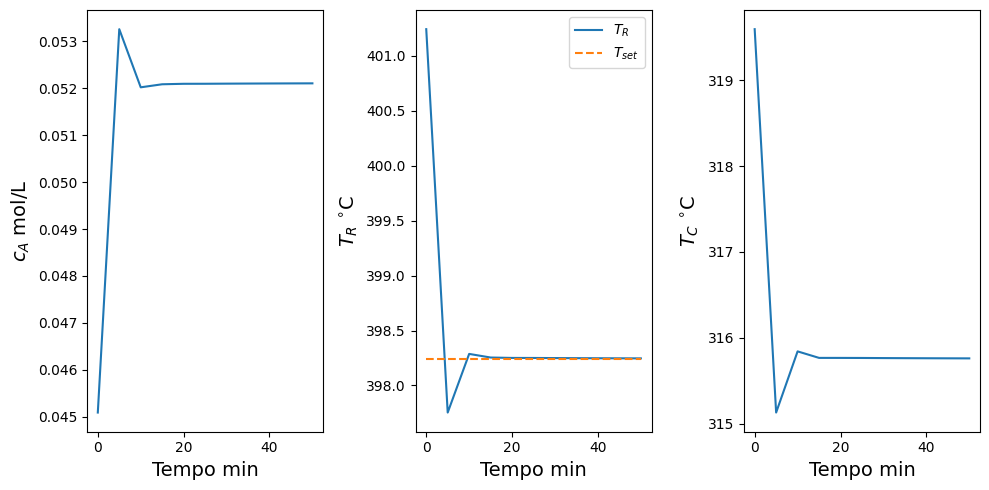

In [21]:
tspan = [0,50]
dt = 5
t = np.arange(tspan[0],tspan[-1]+dt,dt)
N = len(t)

Ym = np.zeros((N,ny))
Um = np.zeros((N,nu))
eC = np.zeros(N)

Ym[0,:] = xeq
Um[0,:] = ueq

x0 = np.zeros(nx)
u0 = np.zeros(nu)

# controlador
Kc = -5
tauI = 5
Tset = xeq[1] - 3
u0_old = u0
erro_old = 0

for j in range(1,N):

    erro = Tset - Ym[j-1,1]
    u0[1] = u0_old[1] + Kc*(erro-erro_old +dt*erro/tauI)
    uC = 0.75*u0_old + 0.25*u0

    # simulação
    Ts = np.array([t[j-1],t[j]]) # tempo
    Us = np.vstack((u0_old, uC))  # entradas

    tsim, ysim = ct.forced_response(sys, T=Ts, X0=x0, U=Us.T)

    # guardando os valores
    Ym[j,:] = ysim[:,-1] + xeq
    Um[j,:] = uC + ueq
    eC[j] = erro

    # atualizando para o proximo tempo
    x0 = ysim[:,-1]
    u0_old = uC
    erro_old = erro


f, ax = plt.subplots(nrows=1, ncols=nx,figsize=(10,5))
ax[0].plot(t,Ym[:,0],label='$T_R$')

ax[1].plot(t,Ym[:,1],label='$T_R$')
ax[1].plot(t,np.ones(N)*Tset,'--', label='$T_{set}$')
ax[1].legend(loc='best')

ax[2].plot(t,Ym[:,2],label='$T_R$')

ax[0].set_xlabel('Tempo min',fontsize=14), ax[0].set_ylabel('$c_A$ mol/L',fontsize=14)
ax[1].set_xlabel('Tempo min',fontsize=14), ax[1].set_ylabel('$T_R$ $^{\circ}$C',fontsize=14)
ax[2].set_xlabel('Tempo min',fontsize=14), ax[2].set_ylabel('$T_C$ $^{\circ}$C',fontsize=14)

plt.tight_layout()
plt.show()